# Import packages

In [1]:
# %matplotlib notebook
from utils import *
from metrics import *
import time
import os

# algorithms
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

from pymoo.factory import get_termination
from pymoo.util.termination import collection

import plotly.express as px
from ipywidgets import *
from skimage.util import compare_images

import pandas as pd

# Reference image

In [2]:
# Image 8
ground_truth_name = '01159-s1-2'
save_results_path = 'output_data/image8-'

In [3]:
image_path = 'input_data/' + ground_truth_name + '.png'
ground_truth_raw, ground_truth = getTargetImage(image_path,0,log=False)

ground_truth_min, ground_truth_max = ground_truth.min(), ground_truth.max()
print(ground_truth_raw.min(), ground_truth_raw.max())
print(ground_truth_min, ground_truth_max)

125.0 255.0
-5.206968 0.5895657


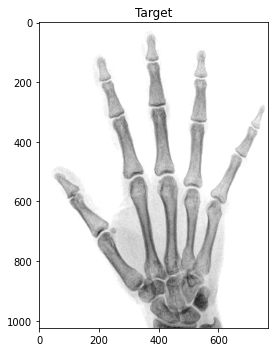

In [4]:
plt.figure(figsize= (5,5))
plt.title("Target")
plt.imshow(ground_truth, cmap='gray')
# plt.axis('off')

plt.tight_layout()


### Pad ground truth, make sure wrist is centred

-5.206968 0.5895657


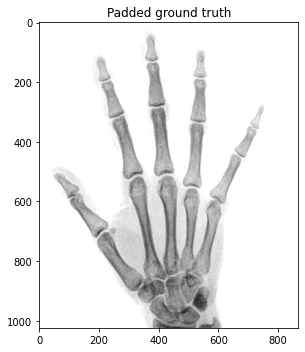

In [5]:
# pad 200 pixels on the right side using the same value as the background
pad_width = 100
ground_truth_pad = np.pad(ground_truth, ((0,0),(0,pad_width)), 'constant', constant_values=ground_truth_max)

print(ground_truth_pad.min(), ground_truth_pad.max())

plt.figure(figsize= (5,5))
plt.title("Padded ground truth")
plt.imshow(ground_truth_pad, cmap='gray')
# plt.axis('off')

plt.tight_layout()

In [6]:
log_ground_truth_raw, log_ground_truth = getTargetImage(image_path,0,log=True)

# use log image
# ground_truth = log_ground_truth

### Image sharpening 

In [7]:
kernel_size = 2
scaling = 5

### Use padded image

In [8]:

ground_truth_sharpen = addSharpenFilterNormalise(ground_truth_pad, kernel_size, scaling, ground_truth_pad.min(), ground_truth_pad.max())


### Use original normalised image

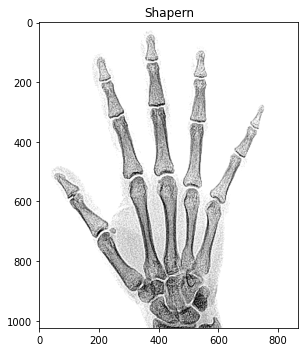

In [9]:

plt.figure(figsize= (5,5))
plt.title("Shapern")
plt.imshow(ground_truth_sharpen, cmap='gray')
# plt.axis('off')

plt.tight_layout()

# 3D hand model

In [10]:
hand_model = plt.imread('input_data/hand_model.png')

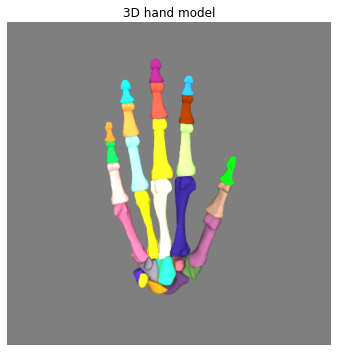

In [11]:
plt.figure(figsize= (10,5))
plt.title("3D hand model")
plt.imshow(hand_model)
plt.axis('off')

plt.tight_layout()

# Set X-ray simulation parameters

In [12]:
model_path = 'input_data/hand.dae'

# add pixels on detector
setXRayEnvironment(model_path, 0, addWidth=pad_width, addHeight=0) 

In [13]:
x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = (x_ray_image-x_ray_image.mean())/x_ray_image.std()

x_ray_image_min, x_ray_image_max = x_ray_image.min(), x_ray_image.max()
print(x_ray_image_min, x_ray_image_max)

-6.91508361240937 0.45943671950625947


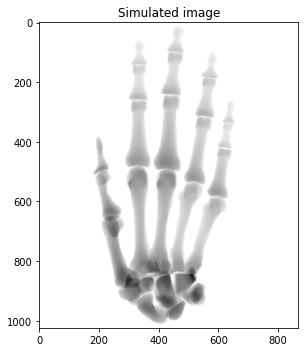

In [14]:
plt.figure(figsize= (10,5))
plt.title("Simulated image")
plt.imshow(x_ray_image, cmap='gray')
# plt.axis('off')

plt.tight_layout()

In [15]:
x_ray_image_sharpen = addSharpenFilterNormalise(x_ray_image, kernel_size, scaling, x_ray_image_min, x_ray_image_max)

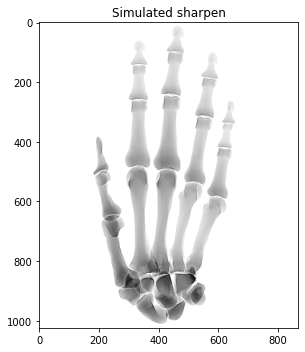

In [16]:
plt.figure(figsize= (10,5))
plt.title("Simulated sharpen")
plt.imshow(x_ray_image_sharpen, cmap='gray')
# plt.axis('off')

plt.tight_layout()

# Matching fingers by hand

# CMA-ES

# NSGA-II

In [17]:
# define boundaries
xl = np.array([0.7, 10., -2., -2., -2.,
            -40., -20., -10.,
            -30., -20., -20., -20.,
            -10., -20., -20., -20.,
            -10., -20., -20. ,-20.,
            0., -20., -20., -20.,
            0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

xu = np.array([0.95, 1000., 2., 2., 2.,
            10., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            30., 0., 0., 0.,
            1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

# ground truth to be used
ground_truth_to_optimise = ground_truth_sharpen

In [18]:
def objectiveFunction(aPrediction):

    obj_list = []

    for i in aPrediction:

        pred_image = computePredictedImage(i)
        pred_image = addSharpenFilterNormalise(pred_image, kernel_size, scaling, pred_image.min(), pred_image.max())

        row = []

        dzncc = (1.0 - ZNCC(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dzncc)
        
        dssim = (1.0 - SSIM(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dssim)

        mae = MAE(ground_truth_to_optimise, pred_image)
        row.append(mae)

        rmse = RMSE(ground_truth_to_optimise, pred_image)
        row.append(rmse)

        dmi = (2.0 - MI(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dmi)
        
        obj_list.append(row)


    return obj_list

In [19]:
class multiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=38, 
                         n_obj=5, 
                         n_constr=0, 
                         xl=xl,
                         xu=xu)


    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.array(objectiveFunction(x))
        

In [20]:
problem = multiObjectiveProblem()

pop_size = 100

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "00:20:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)
# False: #
if False: #os.path.exists(save_results_path+"nsga2-X.dat") and os.path.exists(save_results_path+"nsga2-F.dat"):

    res_nsga2_X = np.loadtxt(save_results_path+"nsga2-X.dat")
    res_nsga2_F = np.loadtxt(save_results_path+"nsga2-F.dat")

else:

    algorithm = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True)

    res_nsga2 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga2_X = res_nsga2.X
    res_nsga2_F = res_nsga2.F

    np.savetxt(save_results_path+"nsga2-X.dat", res_nsga2_X)
    np.savetxt(save_results_path+"nsga2-F.dat", res_nsga2_F)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       2 |            - |            -
    2 |     200 |       2 |  0.00000E+00 |            f
    3 |     300 |       6 |  0.612573993 |        ideal
    4 |     400 |       4 |  0.629873466 |        ideal
    5 |     500 |       3 |  1.284117255 |        ideal
    6 |     600 |       3 |  1.473821046 |        ideal
    7 |     700 |      10 |  0.169931458 |        ideal
    8 |     800 |      11 |  0.279391104 |        ideal
    9 |     900 |      10 |  0.113747970 |        ideal
   10 |    1000 |      13 |  0.166147853 |        ideal
   11 |    1100 |      11 |  0.346683680 |        ideal
   12 |    1200 |       8 |  0.554429042 |        ideal
   13 |    1300 |       7 |  0.084504549 |        ideal
   14 |    1400 |      10 |  0.072610625 |        nadir
   15 |    1500 |      12 |  0.059465516 |        ideal
   16 |    1600 |      15 |  0.109208420 |        ideal
   17 |    1700 |      17 |  0.010475144 |      

In [21]:
best_dzncc_id = np.argmin(res_nsga2_F[:,0])
best_dssim_id = np.argmin(res_nsga2_F[:,1])
best_mae_id = np.argmin(res_nsga2_F[:,2])
best_rmse_id = np.argmin(res_nsga2_F[:,3])
best_dmi_id = np.argmin(res_nsga2_F[:,4])

print("Lowest DZNCC:", res_nsga2_F[:,0].min(), best_dzncc_id, res_nsga2_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga2_F[:,1].min(), best_dssim_id, res_nsga2_X[best_dssim_id])
print("Lowest MAE:",   res_nsga2_F[:,2].min(), best_mae_id,   res_nsga2_X[best_mae_id])
print("Lowest RMSE:",  res_nsga2_F[:,3].min(), best_rmse_id,  res_nsga2_X[best_rmse_id])
print("Lowest DMI:",  res_nsga2_F[:,4].min(), best_dmi_id,  res_nsga2_X[best_dmi_id])

Lowest DZNCC: 0.1832512369479392 5 [  0.90332163 804.88234997  -1.99974128  -0.96709621   1.6671133
 -15.61740433 -11.51645194  -6.27788943 -19.11493928 -18.52670475
 -19.07749003 -15.92060332  -9.78386166 -19.92685514  -9.48775219
 -13.44618604  -4.74031426 -18.9125203  -11.95930277  -1.86300076
  17.38531517 -14.82601581 -14.87218299  -8.40914435   0.93066995
   1.01822303   1.0560921    0.98261027   1.07323121   1.0160509
   1.02035064   1.0713402    0.99338889   1.06617152   1.08655305
   1.07749513   0.95949588   0.94592989]
Lowest DSSIM: 0.16259733582398916 2 [  0.93011831 209.79873178  -1.99881634   0.82412444   1.39098055
 -15.73664355 -11.5050558   -5.76901091 -19.70713022 -17.0660895
 -18.16979718 -15.88534999  -9.70299844 -19.87981965  -8.26283807
  -4.10881042  -4.73629196 -19.89183886  -7.90249433  -0.8215749
  19.2137077  -15.1227403  -14.87836696  -8.13160608   0.93991604
   0.97882484   0.93153799   0.9246332    1.09583384   1.01584137
   1.0228273    1.06797627   0.955

In [22]:
xray_image_dzncc_nsga2 = computePredictedImage(res_nsga2_X[best_dzncc_id])
xray_image_dssim_nsga2   = computePredictedImage(res_nsga2_X[best_dssim_id])
xray_image_mae_nsga2  = computePredictedImage(res_nsga2_X[best_mae_id])
xray_image_rmse_nsga2 = computePredictedImage(res_nsga2_X[best_rmse_id])
xray_image_dmi_nsga2  = computePredictedImage(res_nsga2_X[best_dmi_id])

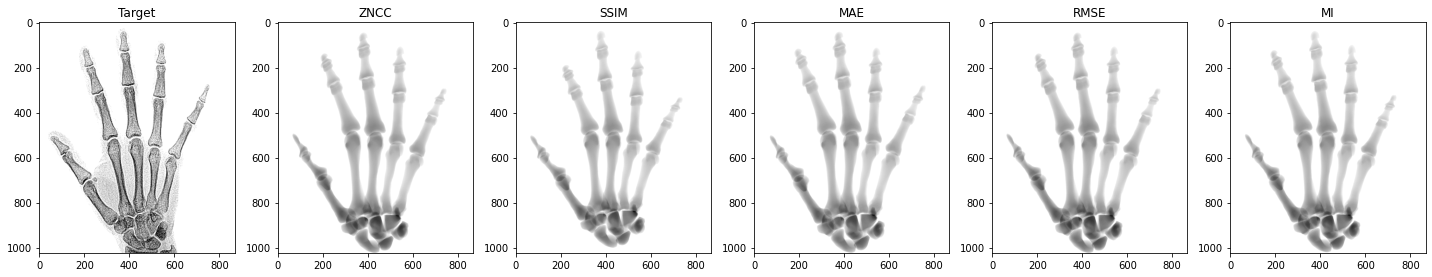

In [23]:
plt.figure(figsize= (20,10))

# plt.suptitle("Results")

plt.subplot(161)
plt.imshow(ground_truth_sharpen, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(162)
plt.imshow(xray_image_dzncc_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("ZNCC")

plt.subplot(163)
plt.imshow(xray_image_dssim_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("SSIM")

plt.subplot(164)
plt.imshow(xray_image_mae_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MAE")

plt.subplot(165)
plt.imshow(xray_image_rmse_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("RMSE")

plt.subplot(166)
plt.imshow(xray_image_dmi_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MI")

plt.tight_layout()

plt.savefig(save_results_path+'nsga2.pdf')
plt.savefig(save_results_path+'nsga2.png')

In [24]:
df_nsga2 = pd.DataFrame(data=np.append(res_nsga2_X, res_nsga2_F, axis=1),
                  columns=["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9",
                           "x10", "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19",
                           "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29",
                           "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37",
                           "DZNCC", "DSSIM", "MAE", "RMSE", "DMI"])

df_nsga2.to_csv(save_results_path+"-nsga2.csv")
print(df_nsga2)

          x0          x1        x2        x3        x4         x5         x6  \
0   0.896843  543.644913 -1.998461  0.676902  1.672044 -14.184570 -12.615113   
1   0.909848  792.034198 -1.999982 -1.115667  1.680710 -15.604194 -12.423955   
2   0.930118  209.798732 -1.998816  0.824124  1.390981 -15.736644 -11.505056   
3   0.930118  209.798732 -1.998816  0.824124  1.392638 -15.736644 -11.505056   
4   0.896635  543.644913 -1.998461  1.255528  1.661316 -14.187154 -11.625119   
..       ...         ...       ...       ...       ...        ...        ...   
95  0.914173  793.495011 -1.999752 -0.793792  1.664372 -16.036772 -11.545054   
96  0.902091  793.039593 -1.999460 -1.078012  1.672095 -15.617404 -11.976835   
97  0.914173  793.495011 -1.999990 -0.793792  1.664372 -16.036772 -11.341442   
98  0.909848  792.102591 -1.999982 -1.134452  1.629418 -15.604194 -11.959091   
99  0.909848  861.117009 -1.999982 -1.115768  1.681117 -15.604194 -12.424715   

          x7         x8         x9  ...

In [25]:
fig = px.parallel_coordinates(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "DMI"]], color="DZNCC")
fig.show()

fig.write_image(save_results_path+"NSGA2-parcoords.pdf", engine="kaleido")
fig.write_image(save_results_path+"NSGA2-parcoords.png", engine="kaleido")

In [26]:
fig = px.scatter_matrix(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "DMI"]])

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(save_results_path+"NSGA2-scatter_matrix.pdf", engine="kaleido")
fig.write_image(save_results_path+"NSGA2-scatter_matrix.png", engine="kaleido")

# Compute orignal images, metrics

In [27]:
# select best individual
total_number_of_params = 38
ind = np.argmin(np.array(df_nsga2.loc[:,'DZNCC']))
print(ind)

5


In [28]:
# Compute x-ray images
x_list = []
for p in range(total_number_of_params):
    x = "x" + str(p)
    x_list.append(df_nsga2.loc[ind,x])
x_list=np.array(x_list)

x_ray_image = computePredictedImage(x_list)
x_ray_image = x_ray_image[:,:768]

In [29]:
# remove padding, compute metrics 
zncc = ZNCC(ground_truth, x_ray_image)
ssim = SSIM(ground_truth, x_ray_image)
mae = MAE(ground_truth, x_ray_image)
rmse = RMSE(ground_truth, x_ray_image)
mi = MI(ground_truth, x_ray_image)

np.savetxt(save_results_path+"nsga2-final-F.dat", [zncc,ssim,mae,rmse,mi])

print('ZNCC:', zncc, 'SSIM:', ssim, 'MAE:', mae, 'RMSE:', rmse, 'MI:', mi)

ZNCC: 0.7322840821233507 SSIM: 0.6584537089294141 MAE: 0.4256135924777531 RMSE: 0.7529787955046751 MI: 1.1076644343488418


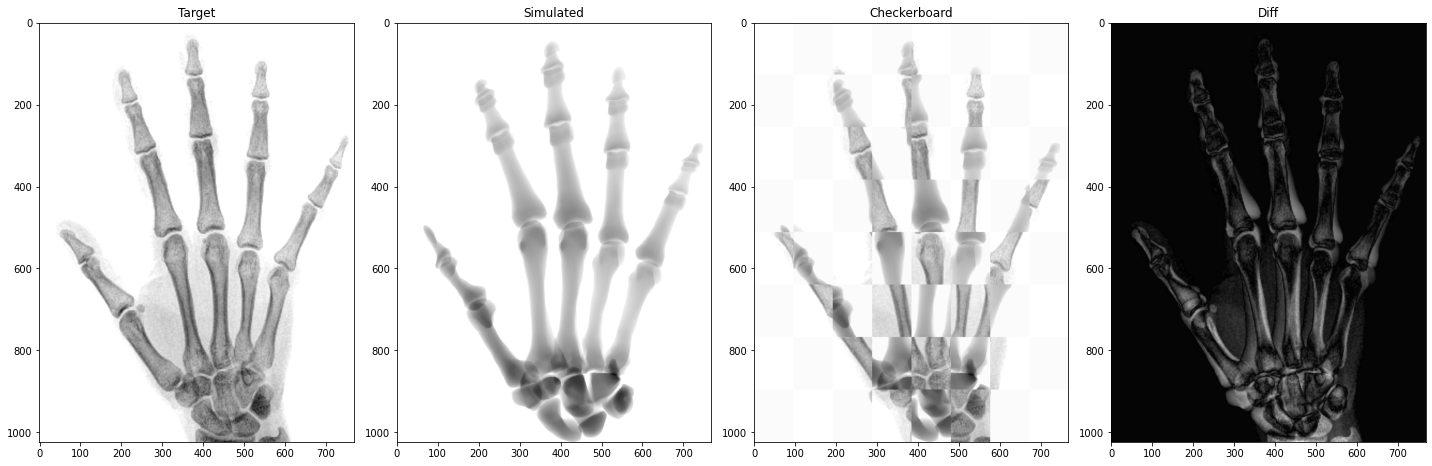

In [30]:


comp_checkerboard = compare_images(ground_truth, x_ray_image, method='checkerboard')
comp_diff = abs(ground_truth-x_ray_image)

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(ground_truth, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(142)
plt.imshow(x_ray_image, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Simulated")

plt.subplot(143)
plt.imshow(comp_checkerboard, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Checkerboard")

plt.subplot(144)
plt.imshow(comp_diff, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Diff")

plt.tight_layout()

plt.savefig(save_results_path+'optimised-nsga2.pdf')
plt.savefig(save_results_path+'optimised-nsga2.png')

In [31]:
#gvxr.destroyAllWindows()